In [31]:
# pip install spektral

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from skimage.util import montage
from IPython.display import Image, display, SVG, clear_output, HTML
plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams["figure.dpi"] = 125
plt.rcParams["font.size"] = 14
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.style.use('ggplot')
sns.set_style("whitegrid", {'axes.grid': False})
plt.rcParams['image.cmap'] = 'gray' # grayscale looks better
import networkx as nx
def draw_graph_mpl(g, pos=None, ax=None, layout_func=nx.drawing.layout.kamada_kawai_layout, draw_labels=True):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(20, 20))
    else:
        fig = None
    if pos is None:
        pos = layout_func(g)
    node_color = []
    node_labels = {}
    shift_pos = {}
    for k in g:
        node_color.append(g.nodes[k].get('color', 'green'))
        node_labels[k] = g.nodes[k].get('label', k)
        shift_pos[k] = [pos[k][0], pos[k][1]]
    
    edge_color = []
    edge_width = []
    for e in g.edges():
        edge_color.append(g.edges[e].get('color', 'black'))
        edge_width.append(g.edges[e].get('width', 0.5))
    nx.draw_networkx_edges(g, pos, font_weight='bold', edge_color=edge_color, width=edge_width, alpha=0.5, ax=ax)
    nx.draw_networkx_nodes(g, pos, node_color=node_color, node_shape='p', node_size=300, alpha=0.75, ax=ax)
    if draw_labels:
        nx.draw_networkx_labels(g, shift_pos, labels=node_labels, arrows=True, ax=ax)
    ax.autoscale()
    return fig, ax, pos

In [33]:
import tensorflow as tf
import graph
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

from spektral.datasets import mnist
from spektral.layers import GraphConv
from spektral.layers.ops import sp_matrix_to_sp_tensor

tf.compat.v1.disable_eager_execution()



# 1. Data Preprocessing

In [34]:
%%time 
# Parameters
l2_reg = 5e-4         # Regularization rate for l2
learning_rate = 1e-3  # Learning rate for SGD
batch_size = 32       # Batch size
epochs = 1         # Number of training epochs
es_patience = 200      # Patience fot early stopping


# Load data
X_train, y_train, X_val, y_val, X_test, y_test, A = mnist.load_data()
X_train, X_val, X_test = X_train[..., None], X_val[..., None], X_test[..., None]
N = X_train.shape[-2]      # Number of nodes in the graphs
F = X_train.shape[-1]      # Node features dimensionality
n_out = 10                 # Dimension of the target


print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(50000, 784, 1) (50000,)
(10000, 784, 1) (10000,)
(10000, 784, 1) (10000,)
CPU times: user 494 ms, sys: 167 ms, total: 661 ms
Wall time: 1.02 s


### draw graph and grid_graph

In [35]:
%%time
def grid_graph(m, k=8, corners=False):
    '''
    To create adjacency matrix as per Defferrard et al. 2016
    '''
    z = graph.grid(m)
    dist, idx = graph.distance_sklearn_metrics(z, k=k, metric='euclidean')
    A = graph.adjacency(dist, idx)

    # Connections are only vertical or horizontal on the grid.
    # Corner vertices are connected to 2 neightbors only.
    if corners:
        import scipy.sparse
        A = A.toarray()
        A[A < A.max()/1.5] = 0
        A = scipy.sparse.csr_matrix(A)
        print('{} edges'.format(A.nnz))

    print("{} > {} edges".format(A.nnz//2, k*m**2//2))
    return A


def draw_graph(A, m=28, ax=None, spring_layout=False, size_factor=10):
    '''Draw the graph given adjacency matrix(A),
    optionally with spring_layout.
    '''
    assert m**2 == A.shape[0] == A.shape[1]
    # Create the nx.Graph object
    G = nx.from_scipy_sparse_matrix(A)
    print('Number of nodes: %d; Number of edges: %d' % \
          (G.number_of_nodes(), G.number_of_edges()))
    grid_coords = graph.grid(m)

    if spring_layout:
        # remove nodes without edges
        nodes_without_edges = [n for n, k in  G.degree() if k == 0]
        G.remove_nodes_from(nodes_without_edges)
        print('After removing nodes without edges:')
        print('Number of nodes: %d; Number of edges: %d' % \
              (G.number_of_nodes(), G.number_of_edges()))
    
    z = graph.grid(m)
    
    # initial positions
    pos = {n: z[n] for n in G.nodes()} 
    
    if spring_layout:
        pos = nx.spring_layout(G, 
                               pos=pos,
                               iterations=200)
    
    ax = nx.draw(G, pos,
                 node_size=[G.degree(n) * size_factor for n in G.nodes()],
                 ax=ax
                )
    return ax

CPU times: user 12 µs, sys: 0 ns, total: 12 µs
Wall time: 15.5 µs


## Goal
The goal of the problem is to correctly classify the digits using the intensity values as the nodes and the neighborhood relationships as the edges. When we visualize the adjacency matrix we can see the effect of a simply unraveled 2D array

(784, 784) adjacency matrix


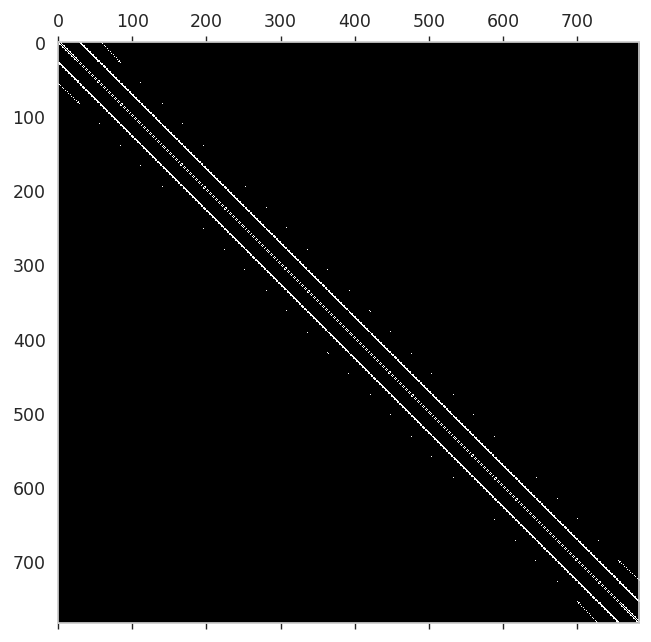

In [36]:
print(A.shape, 'adjacency matrix')
plt.matshow(A.todense())

### visualize the graph


Number of nodes: 784; Number of edges: 3198


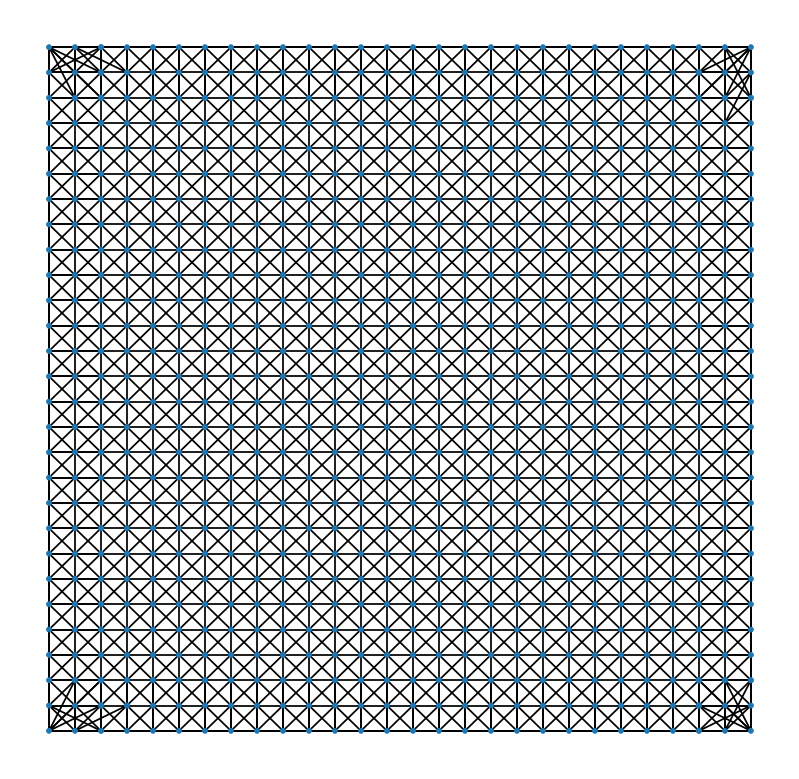

In [37]:
fig, ax = plt.subplots(figsize=(8, 8))
ax = draw_graph(A, ax=ax, size_factor=1)

Number of nodes: 784; Number of edges: 3198
After removing nodes without edges:
Number of nodes: 784; Number of edges: 3198


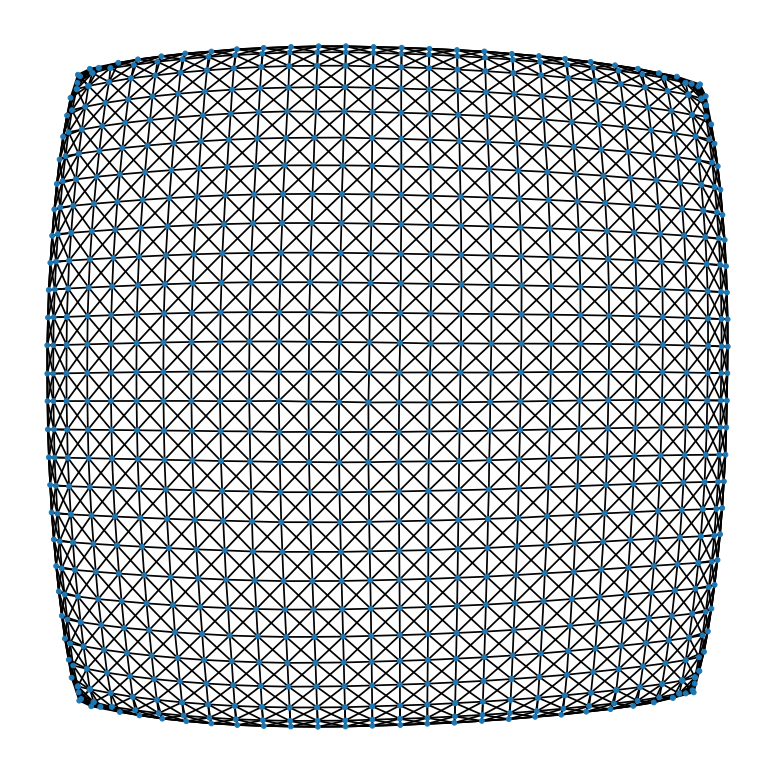

In [38]:
ax = draw_graph(A, ax=ax, size_factor=1, spring_layout=True)

## Label Nodes and Show Connections
Here we can visualize the topology a bit better and see what the graph actually looks like.

In [39]:
xx, yy = np.meshgrid(np.arange(28), np.arange(28))
node_id = ['X:{:02d}_Y:{:02d}'.format(x, y) for x, y in zip(xx.ravel(), yy.ravel())]

In [40]:
print(node_id[10], 'has neighbour nodes as:')
for row, col in zip(*A[10].nonzero()):
    print(col, '->', node_id[col])

X:10_Y:00 has neighbour nodes as:
8 -> X:08_Y:00
9 -> X:09_Y:00
11 -> X:11_Y:00
12 -> X:12_Y:00
37 -> X:09_Y:01
38 -> X:10_Y:01
39 -> X:11_Y:01
66 -> X:10_Y:02


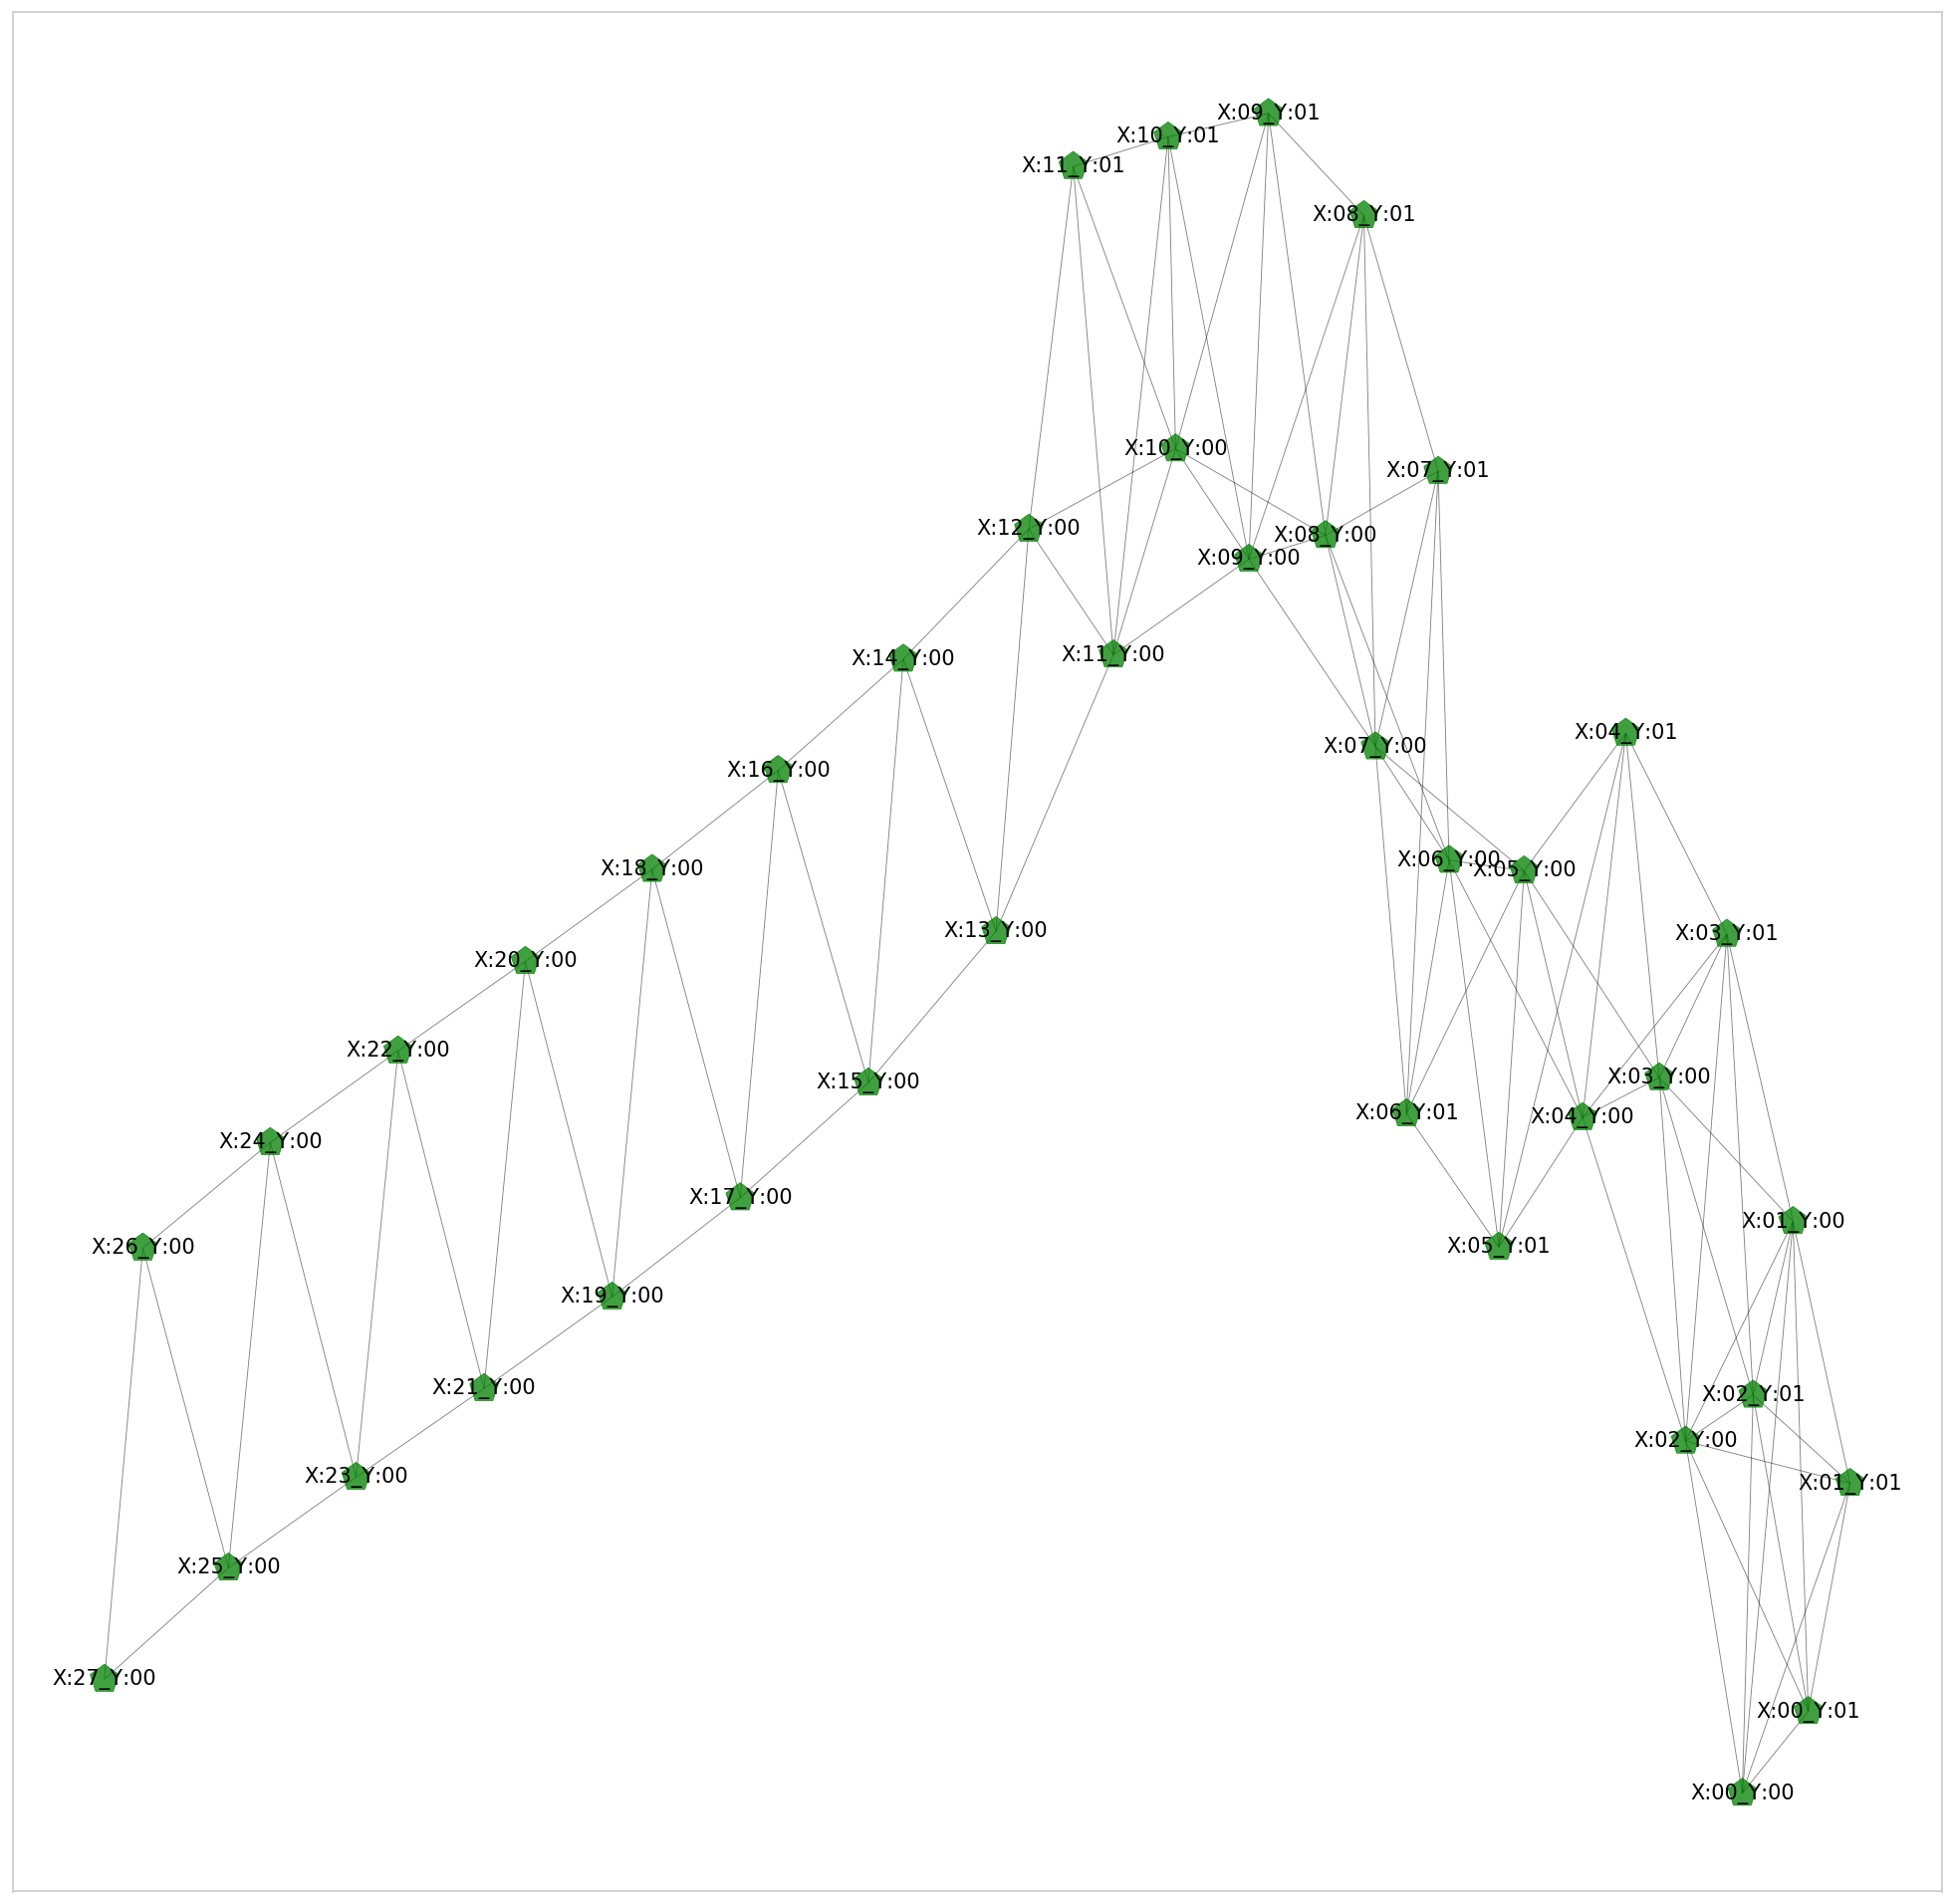

In [41]:
G = nx.from_scipy_sparse_matrix(A[:40, :40])
for k, pix_val in zip(G.nodes, X_train[0]):
    G.nodes[k]['label'] = node_id[k]
draw_graph_mpl(G);

Show 12 rows of the network

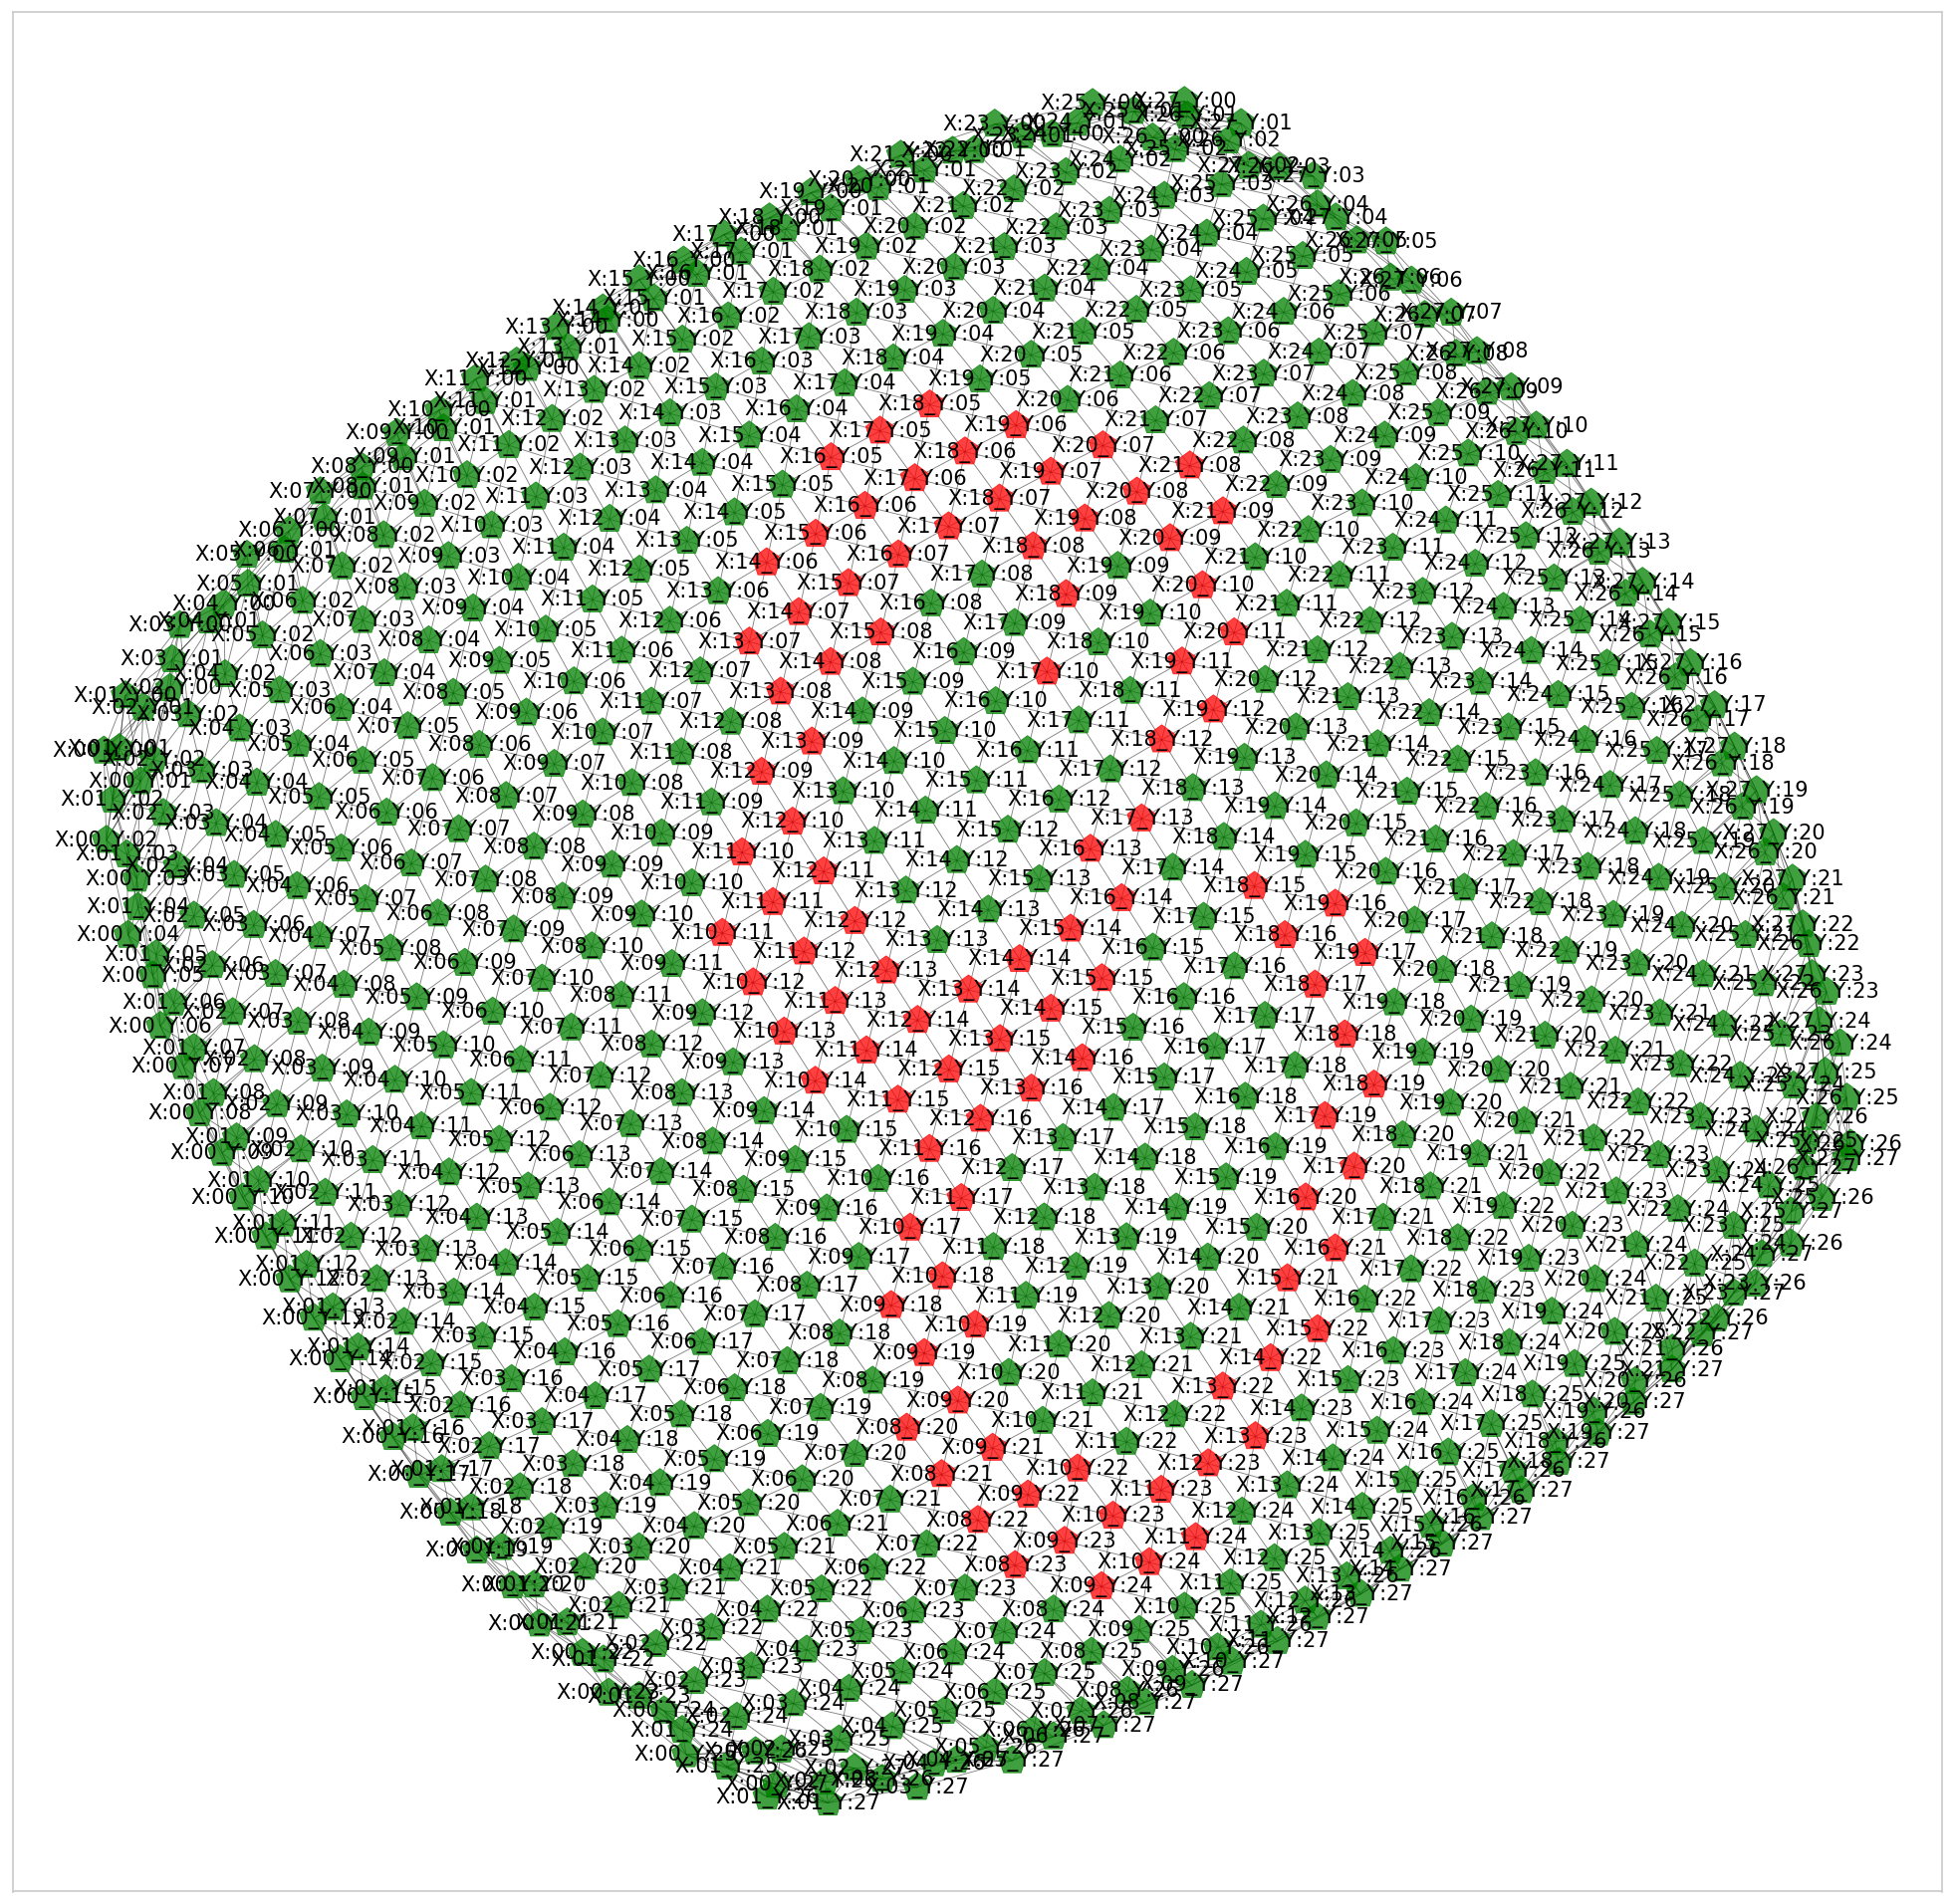

In [42]:
MAX_NODE = 28*28
G = nx.from_scipy_sparse_matrix(A[:MAX_NODE, :MAX_NODE])
for k, pix_val in zip(G.nodes, X_train[0]):
    G.nodes[k]['label'] = node_id[k]
    G.nodes[k]['color'] = 'red' if pix_val>0.5 else 'green'
draw_graph_mpl(G);

Show network (using the X, Y coordinates)

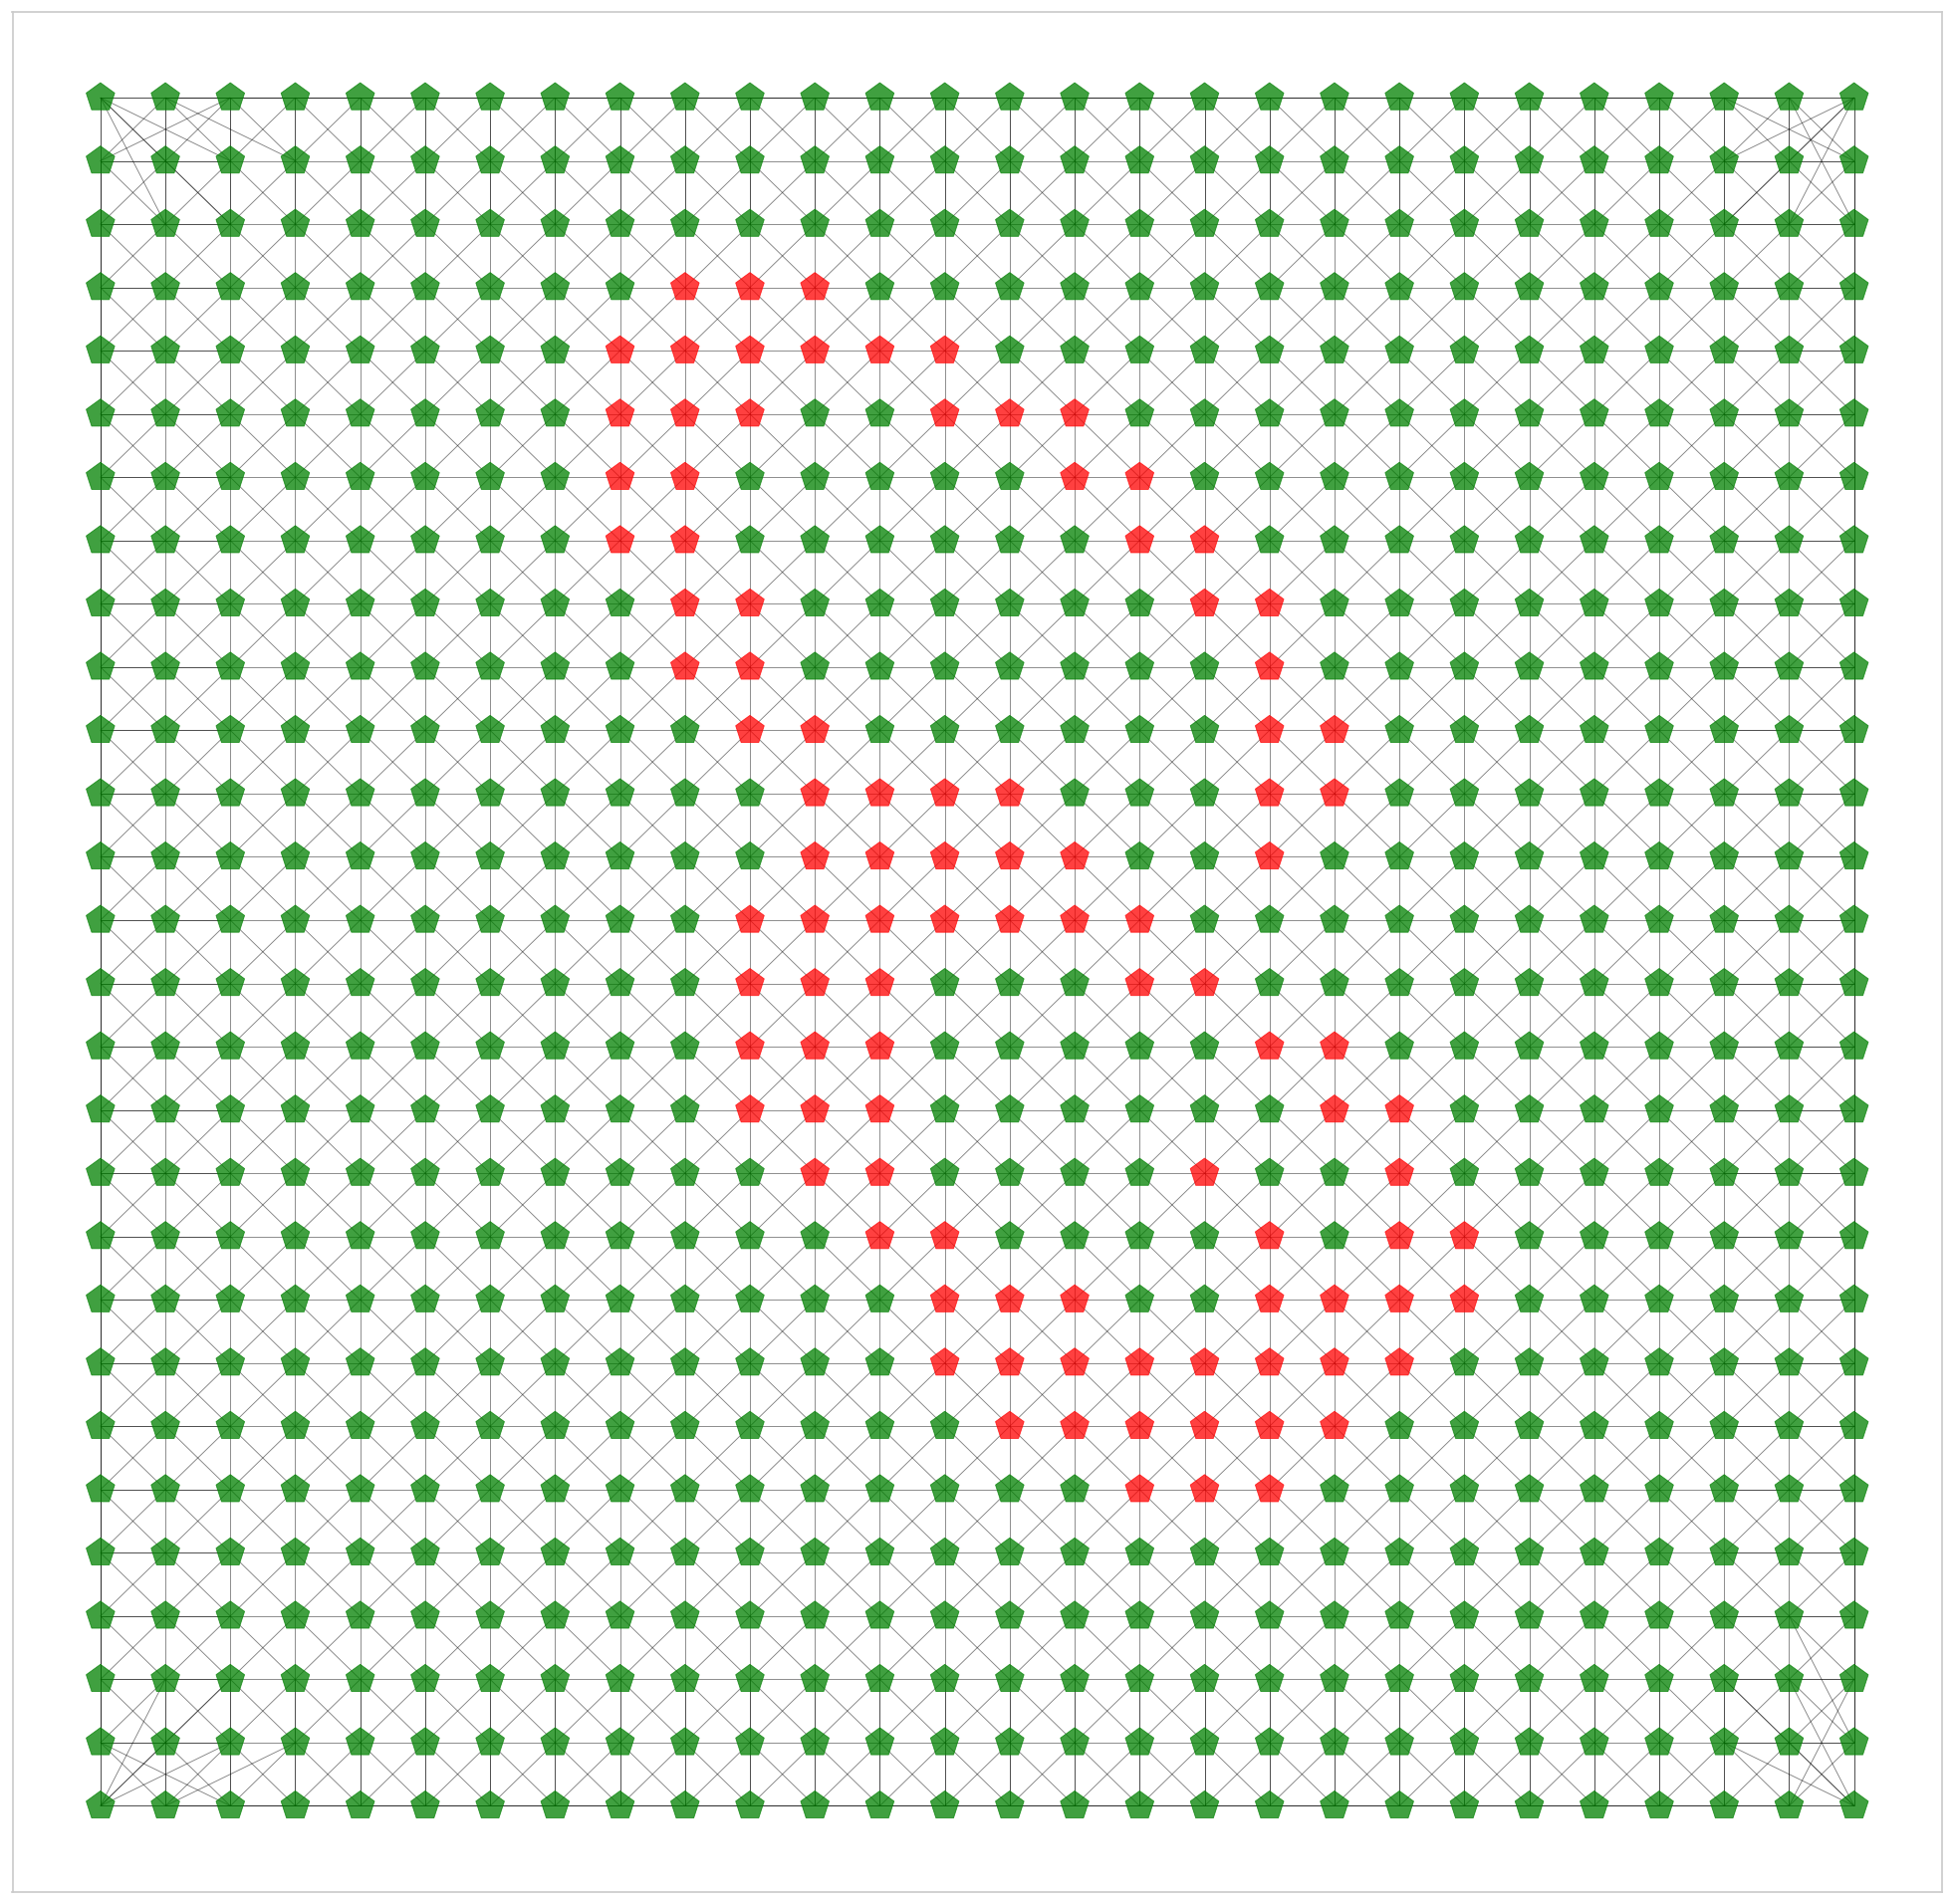

In [43]:
G = nx.from_scipy_sparse_matrix(A)
for k, pix_val in zip(G.nodes, X_train[0]):
    G.nodes[k]['label'] = ''
    G.nodes[k]['color'] = 'red' if pix_val>0.5 else 'green'
draw_graph_mpl(G, pos=np.stack([xx.ravel(), yy.ravel()], -1));

# 2. Model Building

In [44]:
test_scores = []

### 1. Model with densely-connected NN layer

In [45]:
def fc_model(N=28*28, F=1,
                     n_out=10,
                     l2_reg=l2_reg, 
                     learning_rate=learning_rate):
    '''A fully-connected model for MNIST classification.
    '''
    X_in = Input(shape=(N, F))
    
    fc = Dense(10, activation='relu',
               kernel_regularizer=l2(l2_reg),
               use_bias=True)(Flatten()(X_in))
    
    output = Dense(n_out, activation='softmax')(fc)
    
    # Build model
    model = Model(inputs=X_in, outputs=output)
    optimizer = Adam(lr=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['acc'])
    return model
    

In [46]:
X_in = Input(shape=(N, F))
Flatten()(X_in)

<tf.Tensor 'flatten_3/Reshape:0' shape=(None, 784) dtype=float32>

In [47]:
model_fc = fc_model()
model_fc.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 784, 1)]          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                7850      
_________________________________________________________________
dense_5 (Dense)              (None, 10)                110       
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
_________________________________________________________________


In [48]:
validation_data = (X_val, y_val)
model_fc.fit(X_train,
             y_train,
             batch_size=batch_size,
             validation_data=validation_data,
             epochs=epochs)

Train on 50000 samples, validate on 10000 samples
50000/50000 [==============================] - 5s 91us/sample - loss: 0.6002 - acc: 0.8361 - val_loss: 0.3750 - val_acc: 0.9026


In [49]:
# Evaluate model
print('Evaluating model.')
eval_results = model_fc.evaluate(X_test,
                              y_test,
                              batch_size=batch_size)
print('Done.\n'
      'Test loss: {}\n'
      'Test acc: {}'.format(*eval_results))

test_scores.append({
    'model': 'Fully connected',
    'accuracy': eval_results[1]
})

Evaluating model.
10000/10000 [==============================] - 0s 39us/sample - loss: 0.3567 - acc: 0.9046
Done.
Test loss: 0.35670195835828783
Test acc: 0.9046000242233276



### 2. Graph convolutional network for classification with different feature graphs/

Now we can build the model which uses the graph topology shown above as the basis. We feed the topology in as a constant tensor ( Ain ) and the convolutions occur across this topology.

In [50]:
%%time
'''Build a graph convolution network given A.
'''
# Computes a normalized Laplacian (as the conv filter)
fltr = GraphConv.preprocess(A)

# Model definition

# N: Number of nodes in the graphs
# F: Node features dimensionality
X_in = Input(shape=(N, F))

# Pass A as a fixed tensor, otherwise Keras will complain about inputs of
# different rank.
A_in = Input(tensor=sp_matrix_to_sp_tensor(fltr))

graph_conv_1 = GraphConv(32,
                       activation='elu',
                       kernel_regularizer=l2(l2_reg))([X_in, A_in])
graph_conv_2 = GraphConv(32,
                       activation='elu',
                       kernel_regularizer=l2(l2_reg))([graph_conv_1, A_in])

flatten = Flatten()(graph_conv_2)

fc = Dense(512, activation='relu')(flatten)
output = Dense(n_out, activation='softmax')(fc)

# Build model
model = Model(inputs=[X_in, A_in], outputs=output)
optimizer = Adam(lr=learning_rate)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 784, 1)]     0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(784, 784)]         0                                            
__________________________________________________________________________________________________
graph_conv_2 (GraphConv)        (None, 784, 32)      64          input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
graph_conv_3 (GraphConv)        (None, 784, 32)      1056        graph_conv_2[0][0]         

In [51]:
X_in

<tf.Tensor 'input_7:0' shape=(None, 784, 1) dtype=float32>

In [52]:
# Train model
validation_data = (X_val, y_val)
model.fit(X_train,
          y_train,
          batch_size=batch_size,
          validation_data=validation_data,
          epochs=epochs,
          callbacks=[
              EarlyStopping(patience=es_patience, restore_best_weights=True)
          ])

Train on 50000 samples, validate on 10000 samples
50000/50000 [==============================] - 244s 5ms/sample - loss: 0.2502 - acc: 0.9266 - val_loss: 0.1602 - val_acc: 0.9531


In [53]:
# Evaluate model
print('Evaluating model.')
eval_results = model.evaluate(X_test,
                              y_test,
                              batch_size=batch_size)
print('Done.\n'
      'Test loss: {}\n'
      'Test acc: {}'.format(*eval_results))

test_scores.append({
    'model': 'GCN with full grid',
    'accuracy': eval_results[1]
})

Evaluating model.
10000/10000 [==============================] - 15s 1ms/sample - loss: 0.1485 - acc: 0.9563
Done.
Test loss: 0.14848127168118955
Test acc: 0.9563000202178955


In [54]:
test_scores_df = pd.DataFrame(test_scores)
test_scores_df

model  accuracy
0     Fully connected    0.9046
1  GCN with full grid    0.9563

## Weights
Not sure exactly how to interpret these but we can show them easily enough

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

(1, 32) (32,)


<BarContainer object of 32 artists>

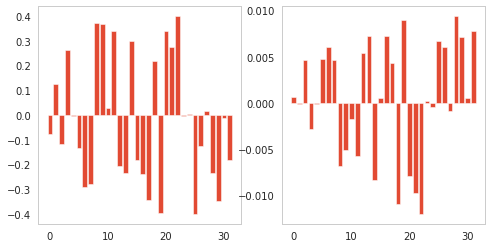

In [56]:
W, b = model.layers[2].get_weights()
print(W.shape, b.shape)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.bar(np.arange(W.shape[1]), W[0])
ax2.bar(np.arange(W.shape[1]), b)

(32, 32) (32,)


<BarContainer object of 32 artists>

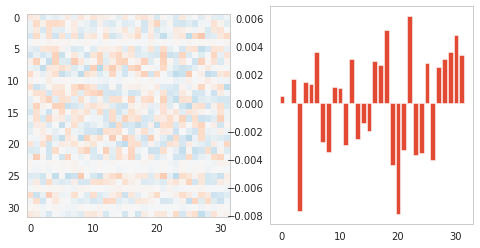

In [57]:
W, b = model.layers[3].get_weights()
print(W.shape, b.shape)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.imshow(W, vmin=-1, vmax=1, cmap='RdBu')
ax2.bar(np.arange(W.shape[1]), b)

## Show intermediate output values
Here we can rearrange the output of the graph convolutions to see if the model is learning similar sorts of features to the standard convolutional neural networks

In [58]:
i_model = Model(inputs=[X_in, A_in], outputs=[graph_conv_1, graph_conv_2])

In [66]:
gc1_out, gc2_out = i_model.predict(X_test[:40])

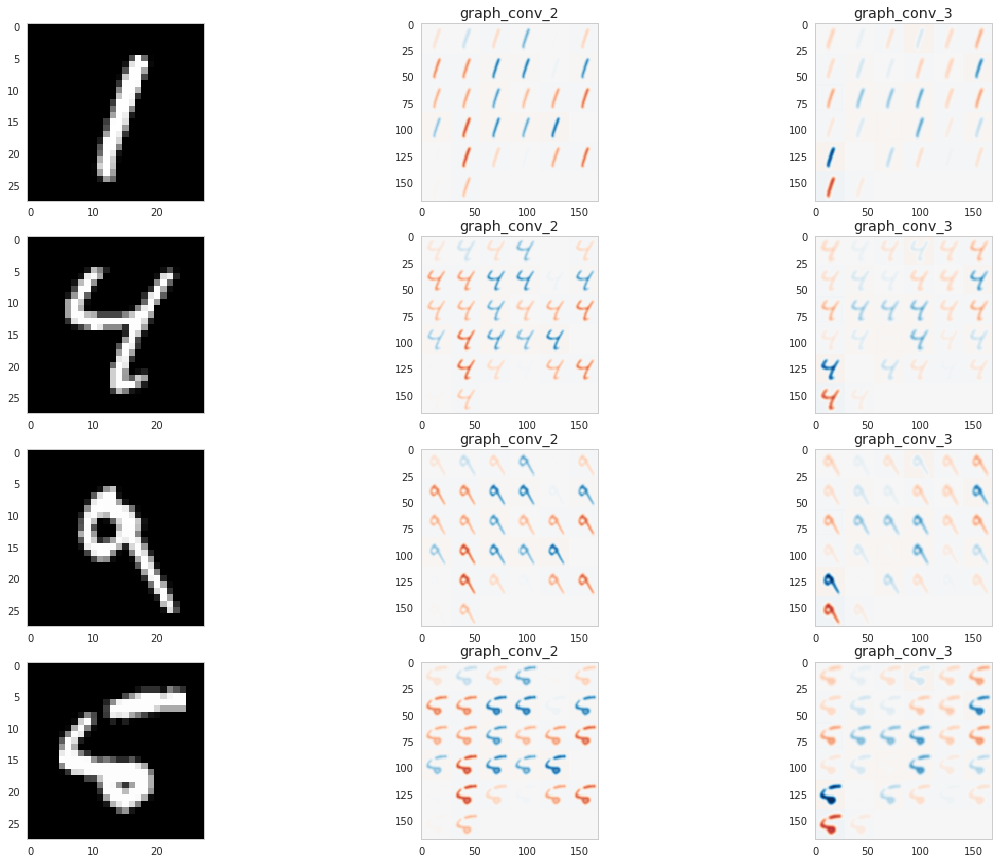

In [71]:
fig, m_axs = plt.subplots(4, 3, figsize=(20, 15))
for i, (ax1, ax2, ax3) in enumerate(m_axs):
    ax1.imshow(X_test[i+5].reshape((28, 28)))
    gc_stack = gc1_out[i+5].reshape((28, 28, -1)).swapaxes(0, 2).swapaxes(1, 2)
    ax2.imshow(montage(gc_stack), vmin=-0.5, vmax=0.5, cmap='RdBu')
    ax2.set_title(i_model.output_names[0])
    gc_stack = gc2_out[i+5].reshape((28, 28, -1)).swapaxes(0, 2).swapaxes(1, 2)
    ax3.imshow(montage(gc_stack), vmin=-0.5, vmax=0.5, cmap='RdBu')
    ax3.set_title(i_model.output_names[1])